# 決定木
## 欠損値補完
* Fare: 欠損レコードの「Pclass=3」「Embarked=S」の平均運賃(=14.43)で補完
* Embarked: 欠損レコードは共に「Pclass=1st」。条件付き確率の最も高い「S」で補完

## 外れ値処理
* 木系のため特に実施せず

## 特徴量
* Pclass: そのまま利用
* Sex: Label Count Rank Encoding
* Age: 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」にカテゴリ化しLabel Count Rank Encoding
* SibSp: そのまま利用
* Parch: そのまま利用
* Fare: そのまま利用
* Embarked: Label Count Rank Encoding

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from titanic_package.titanic_preprocess import get_age_ctgr
from titanic_package.titanic_preprocess import get_binned_data
from titanic_package.titanic_preprocess import calc_label_count_rank_encoding

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
# Data load
titanic_train = pd.read_csv('./data/train.csv')
titanic_test = pd.read_csv('./data/test.csv')

In [3]:
# 学習/評価データをマージ
titanic_train['Type'] = 'train'
titanic_test['Type'] = 'test'
titanic_test['Survived'] = np.NaN

titanic_all = pd.concat([titanic_train, titanic_test], ignore_index=True, sort=True)
train_flg = titanic_all['Type'] == 'train'
test_flg = titanic_all['Type'] == 'test'

In [4]:
# 欠損値補完
# Fare
## 運賃は「チケットクラス」「乗船港」で決まると考える
## 欠損レコードは「Pclass=3」「Embarked=S」なのでその平均運賃で補完する
f = (titanic_all['Pclass'] == 3) & (titanic_all['Embarked'] == 'S')
fare_mean = np.mean(titanic_all[f]['Fare'].dropna())

titanic_all['Fare'] = titanic_all['Fare'].fillna(fare_mean)

# Embarked
## 欠損の2人は1stクラス。条件付き確率が最も高い「S」で補完
titanic_all['Embarked'] = titanic_all['Embarked'].fillna('S')

In [5]:
# 年齢カテゴリを作成
## 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
age_ctgr_list = []

for index, row in titanic_all.iterrows():
    age_ctgr = get_age_ctgr(row['Age'], row['Pclass'])
    age_ctgr_list.append(age_ctgr)

titanic_all['AgeCtgr'] = age_ctgr_list

In [6]:
# カテゴリ変数のエンコーディング
## Label Count Rank Encoding

## 性別
titanic_all['Sex_code'] = calc_label_count_rank_encoding(titanic_all, 'Sex')

## 年齢カテゴリ
titanic_all['AgeCtgr_code'] = calc_label_count_rank_encoding(titanic_all, 'AgeCtgr')

## 出港地
titanic_all['Embarked_code'] = calc_label_count_rank_encoding(titanic_all, 'Embarked')

In [7]:
# 学習／テスト用データに分割
features = ['Pclass', 'Sex_code', 'AgeCtgr_code', 'SibSp', 'Parch', 'Fare', 'Embarked_code']
X = titanic_all[features]

X_train = X[train_flg]
y_train = titanic_all[train_flg]['Survived'].astype(int)

X_test = X[test_flg]

## 決定木

[Text(279.0, 271.8, 'Sex_code <= 1.5\nsamples = 100.0%\nvalue = [0.616, 0.384]'),
 Text(139.5, 163.08, 'Fare <= 26.269\nsamples = 64.8%\nvalue = [0.811, 0.189]'),
 Text(69.75, 54.360000000000014, 'samples = 46.6%\nvalue = [0.87, 0.13]'),
 Text(209.25, 54.360000000000014, 'samples = 18.2%\nvalue = [0.66, 0.34]'),
 Text(418.5, 163.08, 'Pclass <= 2.5\nsamples = 35.2%\nvalue = [0.258, 0.742]'),
 Text(348.75, 54.360000000000014, 'samples = 19.1%\nvalue = [0.053, 0.947]'),
 Text(488.25, 54.360000000000014, 'samples = 16.2%\nvalue = [0.5, 0.5]')]

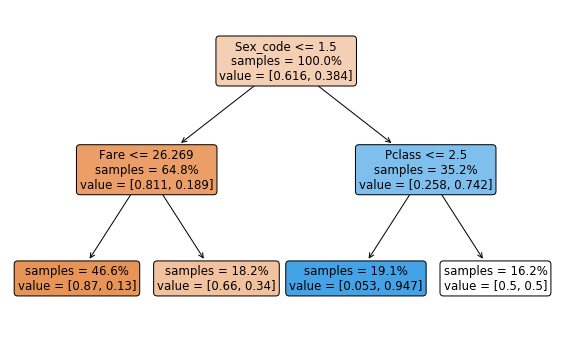

In [8]:
model = DecisionTreeClassifier(max_depth=2)

model.fit(X_train, y_train)

fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, proportion=True, impurity=False, ax=ax)